# **Episode I: The Tensor Force Awakens**

## 1. Introduction

This notebook is a direct application of the course [Object Localization with tensorflow](https://www.coursera.org/projects/object-localization-tensorflow) freely available on coursera, please refer to this source for in depth explanation. Modifications have been applied to account for the specific context, an updated tensorflow version, a modified IoU metric and tensorboard support.

Here we aim at performing object localization for a cartoon space journey. Images are made up of overlayed cartoon planets, asteroids and more, over a deep space background.


## 2. Installation and Initialisation

This notebook runs smoothly on a docker image (latest 06/2023) of tensorflow with jupyter and gpu support, the container is launched from a terminal from the `AIpprenticeChronicles` folder using the command 
```
docker run --gpus all -it -v $PWD:/tf -w /tf -p 8888:8888 tensorflow/tensorflow:latest-gpu-jupyter
``` 
To run without docker please refer to the `requirements.txt` file for exact packages versions. 


In [1]:
# install tqdm to display progress bars
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm 

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

tf.random.set_seed(42)

# to prevent some warnings 
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
# check GPU availability, the code can run on cpu 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# this cell might throw message but this should be harmless

2023-07-01 12:33:49.330626: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-01 12:33:49.460471: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-07-01 12:33:51.141991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 12:33:51.157226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 12:33:51.157378: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## 3. Data Preparation
The first script defines a set of basic objects to create training images. The set includes various planets, celestial bodies, and space objects. Each object is associated with a name, image file, and code. The second script load background images and prepares the planet images for further processing by cropping and converting them to RGBA format. The third script produces a dataset of of 1000 images and displays the first 100. Finally the last script defines a data generator to feed the training loop with batches of data.

In [3]:
# Define a dictionary to store information about different objects
objects = {
    0: {'name': 'Sun', 'file': 'sun.png', 'code': 'SU'},
    1: {'name': 'Earth', 'file': 'earth.png', 'code': 'EA'},
    2: {'name': 'Mars', 'file': 'mars.png', 'code': 'MA'},
    3: {'name': 'Venus', 'file': 'venus.png', 'code': 'VE'},
    4: {'name': 'Jupiter', 'file': 'jupiter.png', 'code': 'JU'},
    5: {'name': 'Mercury', 'file': 'mercury.png', 'code': 'ME'},
    6: {'name': 'Saturn', 'file': 'saturn2.png', 'code': 'SA'},
    7: {'name': 'Neptune', 'file': 'neptune.png', 'code': 'NE'},
    8: {'name': 'Uranus', 'file': 'uranus.png', 'code': 'UR'},
    9: {'name': 'Asteroid', 'file': 'asteroid.png', 'code': 'AS'},
    10: {'name': 'Black Hole', 'file': 'black-hole.png', 'code': 'BL'},
    11: {'name': 'Star Destroyer', 'file': 'star-destroyer.png', 'code': 'ST'}
}

# Get the total number of objects
n_objects = len(objects)

# Define a list to store background images
bg = []
bg.append(Image.open(r"../img/background/bg1.jpg"))
bg.append(Image.open(r"../img/background/bg2.jpg"))
bg.append(Image.open(r"../img/background/bg3.jpg"))

# Set the directory path for object images
im_dir = '../img/objects'

# Loop through each object in the objects dictionary
for class_id, values in objects.items():
    # Open and convert the image file for the current planet
    png_file = Image.open(os.path.join(im_dir, values['file'])).convert('RGBA')
    
    # Crop the image to a square shape using the maximum dimension
    png_file = png_file.crop((0, 0, np.max(png_file.size), np.max(png_file.size)))
    
    # Store the processed image in the objects dictionary
    objects[class_id]['image'] = png_file


This script contains functions to generate images by overlaying objects onto background images. The 'get_bg' function randomly selects a background image and crops it to a specified size. The 'put_object' function resizes the object image, randomly positions it on the background, and returns the modified background along with the coordinates and size of the object.

In [4]:
# Function to get a random background image and crop it
def get_bg(bg): 
    id_bg = np.random.randint(0, 3)  # Randomly select a background image index
    bg_tmp = bg[id_bg]  # Get the selected background image
    (w, h) = bg_tmp.size  # Get the dimensions of the background image
    x1 = np.random.randint(0, w - bg_size)  # Randomly choose x-coordinate for cropping
    y1 = np.random.randint(0, h - bg_size)  # Randomly choose y-coordinate for cropping
    bg_tmp = bg_tmp.crop((x1, y1, x1 + bg_size, y1 + bg_size))  # Crop the background image
    return bg_tmp

# Function to overlay a planet onto the background image
def put_object(obj, bg_tmp):
    h = obj.size[0]  # Get the size of the object image
    if h >= bg_size:
        scale = 0.4 * np.random.random() + 0.1  # Randomly choose a scale for large object
    else:
        scale = 0.7 * np.random.random() + 0.1  # Randomly choose a scale for small object
    h = np.int32(scale * h)  # Calculate the new size of the object image based on the scale
    p = obj.resize((h, h))  # Resize the object image
    h_bg = bg_tmp.size[0]  # Get the size of the background image
    x = np.random.randint(0, h_bg - h)  # Randomly choose x-coordinate for placing the object
    y = np.random.randint(0, h_bg - h)  # Randomly choose y-coordinate for placing the object
    bg_tmp.paste(p, (x, y), mask=p)  # Paste the object onto the background image
    return bg_tmp, x, y, h


The following script generates the data set and displays the first 100 images

Generating training set...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:40<00:00, 99.16it/s]


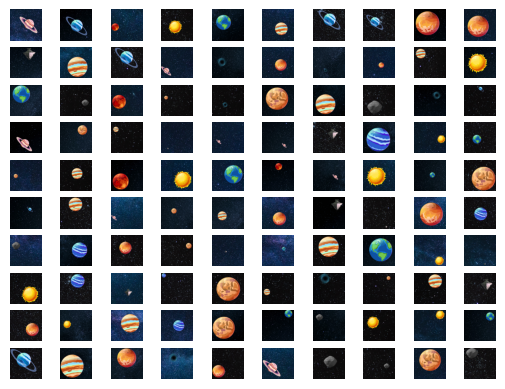

In [5]:
# Function to create a single example for the dataset
def create_example():
    class_id = np.random.randint(0, n_objects)  # Randomly choose a class ID
    bg_tmp = get_bg(bg)  # Get a random background image
    plan_im = objects[class_id]['image']  # Get the image of the chosen class
    img, x, y, h = put_object(plan_im, bg_tmp)  # Overlay the object on the background
    img = img.resize((im_size, im_size))  # Resize the image to the desired size
    x1 = np.float32(x) / bg_size  # Normalize x-coordinate of the object's position
    y1 = np.float32(y) / bg_size  # Normalize y-coordinate of the object's position
    h = np.float32(h) / bg_size  # Normalize size of the object
    return img, class_id, x1, y1, h

# Function to create the dataset
def create_dataset(set_size):
    dataset = []
    for i in tqdm(range(set_size)):
        image, class_id, x1, y1, h = create_example()
        dataset.append([image, class_id, x1, y1, h])
    return dataset

bg_size = 800  # Size of the background image
im_size = 144  # Size of the resized images

print('Generating training set...')
dataset = create_dataset(10000)  # Create a dataset of 1000 examples

# display first 100 images
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(dataset[10*i+j][0])
        plt.axis('off')

The script defines a data generator for TensorFlow, which generates batches of data during training

In [24]:
# Data generator for TensorFlow
def data_generator(batch_size):
    while True:
        x_batch = np.zeros((batch_size, im_size, im_size, 3))  # Initialize batch of input images
        y_batch = np.zeros((batch_size, n_objects))  # Initialize batch of class labels
        bbox_batch = np.zeros((batch_size, 3))  # Initialize batch of bounding box coordinates

        for i in range(0, batch_size):
            image, class_id, x1, y1, h = random.choice(dataset)  # Randomly select an example from the dataset
            x_batch[i] = np.array(image) / 255.  # Normalize and assign the image to the batch
            y_batch[i, class_id] = 1.0  # Set the class label of the corresponding object to 1.0
            bbox_batch[i] = np.array([x1, y1, h])  # Assign the normalized bounding box coordinates to the batch
            
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}  # Yield the batch of input images and corresponding labels


## 4. Metrics and Model definition

The IoU (Intersection over Union) metric is used to evaluate the accuracy of object localization models. It measures the overlap between the predicted bounding box and the ground truth bounding box. IoU is computed as the ratio of the intersection area to the union area, providing a measure of how well the predicted box aligns with the ground truth.

The Convolutional Neural Network (CNN) model used in this notebook is designed for object classification and bounding box regression. It consists of multiple convolutional and pooling layers to extract features from input images. The extracted features are then flattened and passed through fully connected layers to predict the class probabilities and bounding box coordinates. The model is trained using categorical cross-entropy loss for classification and mean squared error loss for bounding box regression.

#### IoU metric

In [25]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self,**kwargs):
        super(IoU,self).__init__(**kwargs)
        
        self.iuo=self.add_weight(name='iou',initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros') 
        self.num_ex = self.add_weight(name='num_ex',initializer='zeros') 
        
    def update_state(self,y_true,y_pred,sample_weight=None):
        def get_box(y):
            x1, y1, h = y[:,0], y[:,1], y[:,2]
            x1, y1, h = im_size*x1, im_size*y1, im_size*h 
            return x1,y1,h
        
        def get_area(h):
            return h*h
        
        gt_x1,gt_y1,gt_h = get_box(y_true)
        pr_x1,pr_y1,pr_h = get_box(y_pred)
        
        dx = tf.minimum(gt_x1+gt_h, pr_x1+pr_h) - tf.maximum(gt_x1, pr_x1)
        dy = tf.minimum(gt_y1+gt_h, pr_y1+pr_h) - tf.maximum(gt_y1, pr_y1)
        inter_test=tf.math.logical_and(tf.math.greater(dx,0.),tf.math.greater(dy,0.))
        i_area=tf.cast(inter_test,tf.float32)*dx*dy
        
        u_area=get_area(gt_h)+get_area(pr_h)-i_area
        
        iou= tf.math.divide(i_area,u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou,self.num_ex)

    def result(self):
        return self.iou        

    def reset_state(self):
        self.iou =self.add_weight(name='iou',initializer ='zeros')
        self.total_iou = self.add_weight(name='total_iou',initializer='zeros') 
        self.num_ex = self.add_weight(name='num_ex',initializer='zeros') 

#### Convolution neural network

In [26]:
# Define the input layer
input_ = Input(shape=(im_size, im_size, 3), name='image')

# Start building the model architecture
x = input_
for i in range(0, 5):
    n_filters = 2**(4 + i)  # Calculate the number of filters for each convolutional layer
    x = Conv2D(n_filters, 3, activation='relu')(x)  # Add a convolutional layer with ReLU activation
    x = BatchNormalization()(x)  # Add batch normalization to normalize the activations
    x = MaxPool2D(2)(x)  # Add a max pooling layer with pool size of 2x2

x = Flatten()(x)  # Flatten the output from the convolutional layers
x = Dense(128, activation='relu')(x)  # Add a dense layer with ReLU activation
class_out = Dense(n_objects, activation='softmax', name='class_out')(x)  # Output layer for class prediction
box_out = Dense(3, name='box_out')(x)  # Output layer for bounding box prediction

# Create the model with input and output layers
model = tf.keras.models.Model(input_, [class_out, box_out])

# Display a summary of the model architecture
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 142, 142, 16  64         ['conv2d_10[0][0]']              
 ormalization)                  )                                                           

## 5. Training loop

The training loop follows a multi-step process. It includes a learning rate scheduler, early stopping, and a custom callback to visualize test images during training. The model is compiled with appropriate loss functions and metrics for classification and bounding box regression. The loop iterates over the dataset, updating the model's weights, and monitors performance using callbacks for visualization and stopping criteria.

Training model
Epoch 1/30


2023-07-01 12:43:05.515578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 7s 10ms/step - loss: 0.7917 - class_out_loss: 0.6307 - box_out_loss: 0.1610 - class_out_accuracy: 0.8052 - box_out_iou: 0.1004 - lr: 0.0010
Epoch 2/30
500/500 [==============================] - 5s 10ms/step - loss: 0.1614 - class_out_loss: 0.1213 - box_out_loss: 0.0401 - class_out_accuracy: 0.9652 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 3/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0835 - class_out_loss: 0.0619 - box_out_loss: 0.0216 - class_out_accuracy: 0.9809 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 4/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0959 - class_out_loss: 0.0789 - box_out_loss: 0.0171 - class_out_accuracy: 0.9744 - box_out_iou: 0.0000e+00 - lr: 0.0010
Epoch 5/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0433 - class_out_loss: 0.0347 - box_out_loss: 0.0086 - class_out_accuracy: 0.9901 - box_out_iou: 0.0000e+00 - lr: 2.0000e-04
Epoch 6/30
500/500 [=

500/500 [==============================] - 5s 10ms/step - loss: 0.0038 - class_out_loss: 8.0881e-04 - box_out_loss: 0.0030 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 4.0000e-05
Epoch 15/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0038 - class_out_loss: 8.9891e-04 - box_out_loss: 0.0029 - class_out_accuracy: 0.9999 - box_out_iou: 0.0000e+00 - lr: 8.0000e-06
Epoch 16/30
500/500 [==============================] - 5s 10ms/step - loss: 0.0035 - class_out_loss: 7.3400e-04 - box_out_loss: 0.0028 - class_out_accuracy: 1.0000 - box_out_iou: 0.0000e+00 - lr: 8.0000e-06


INFO:tensorflow:Assets written to: Episode1_00/assets


INFO:tensorflow:Assets written to: Episode1_00/assets


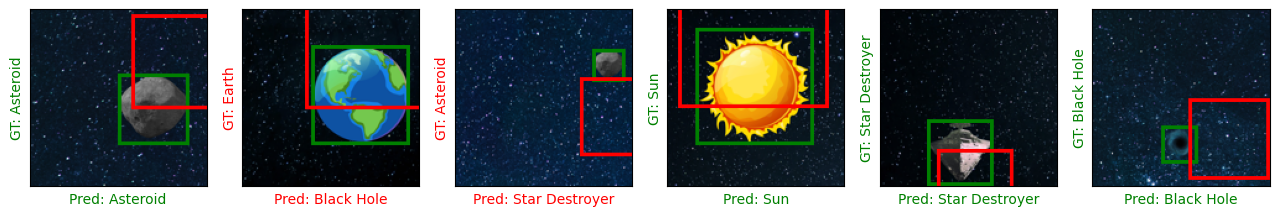

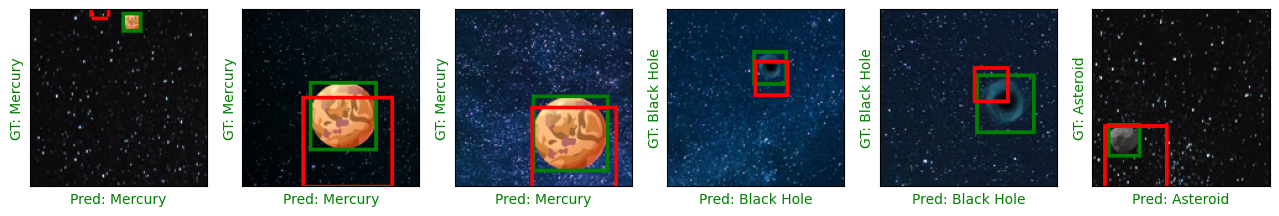

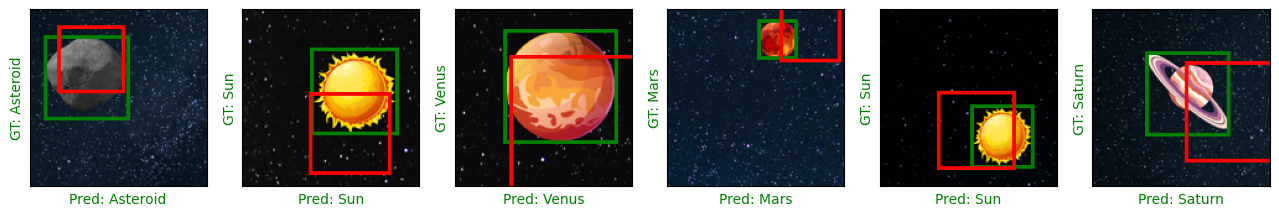

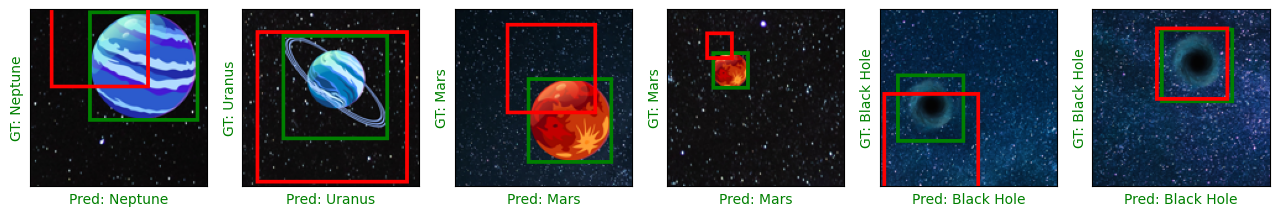

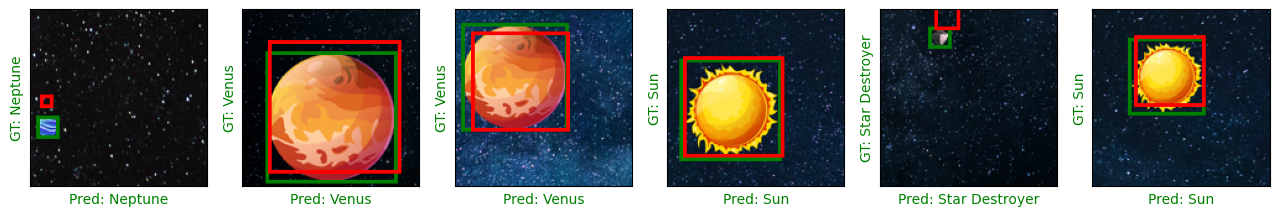

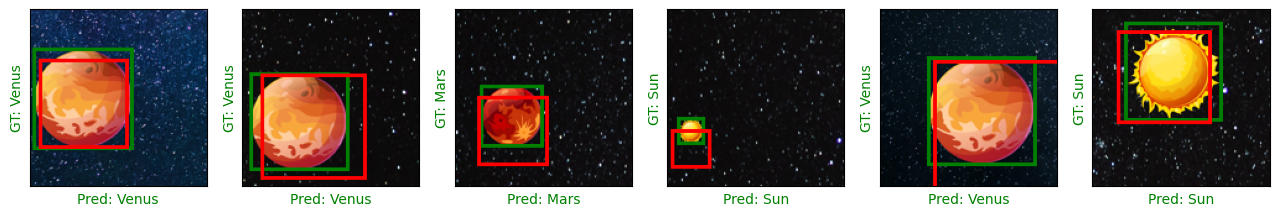

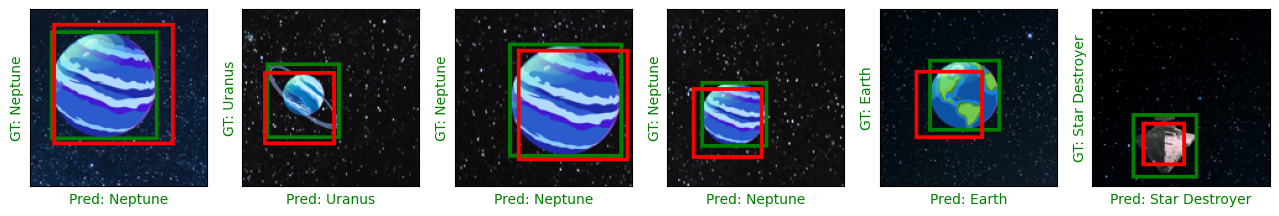

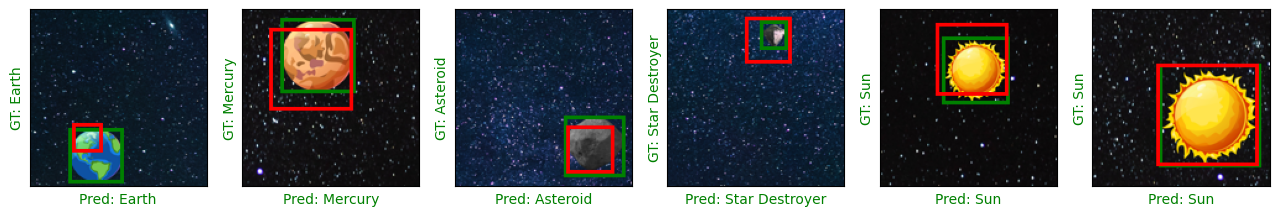

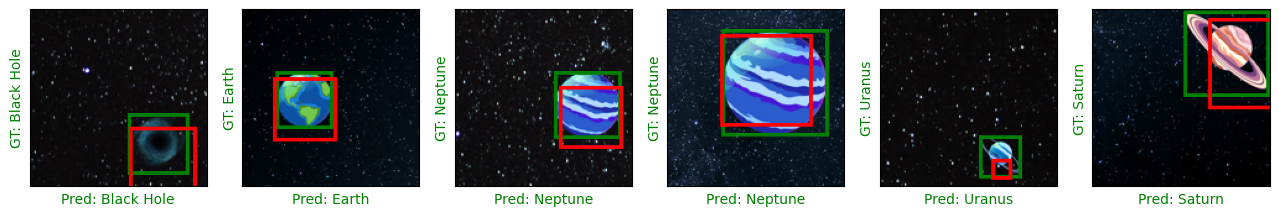

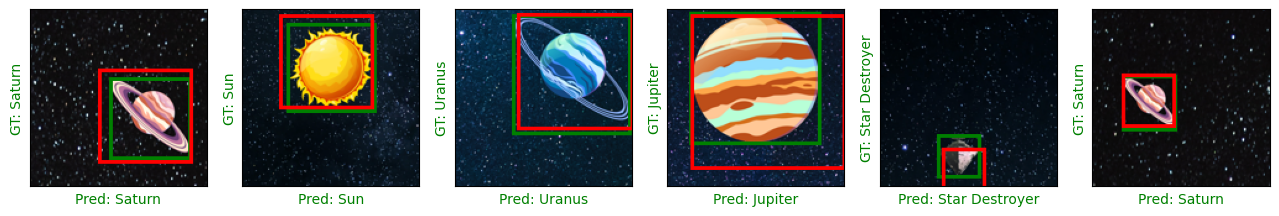

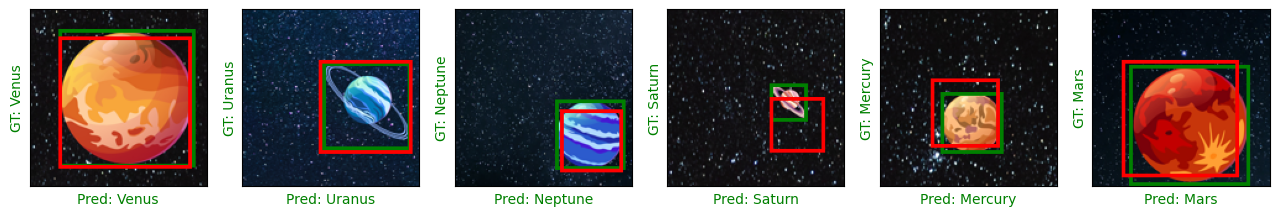

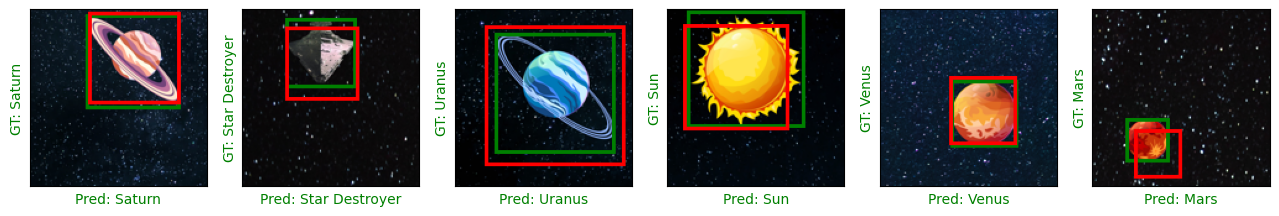

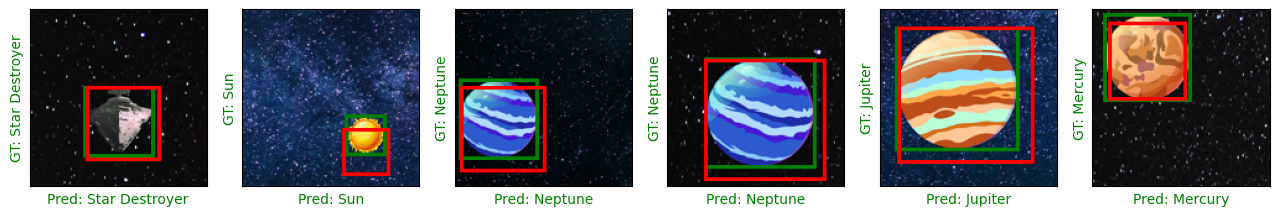

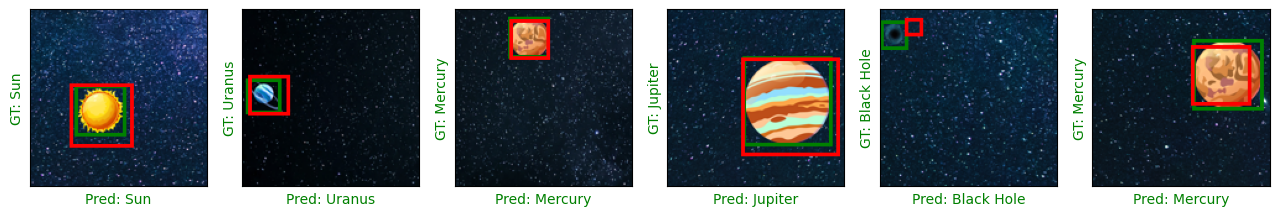

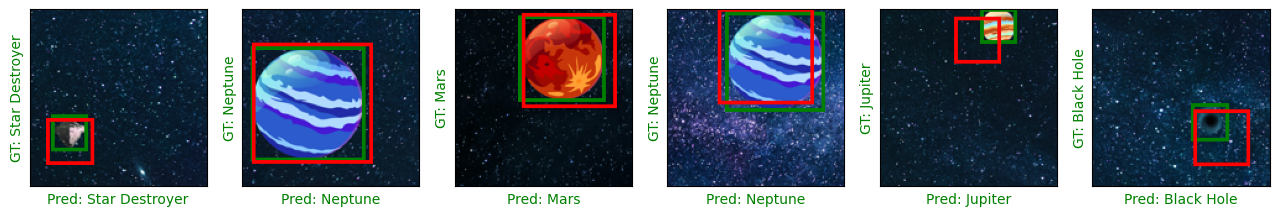

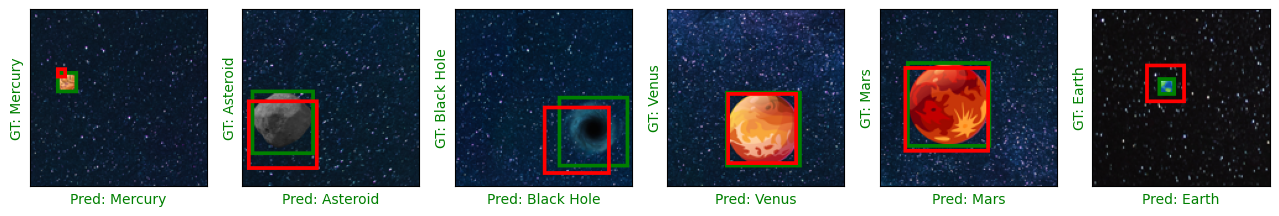

In [27]:
# Function to plot bounding boxes on an image
def plot_bounding_box(image, gt_coords, pred_coords, norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    # Plot ground truth bounding box
    [x1, y1, h] = gt_coords
    x1 *= im_size
    y1 *= im_size
    h *= im_size
    draw.rectangle([x1, y1, x1 + h, y1 + h], outline='green', width=3)
    
    # Plot predicted bounding box (if available)
    if len(pred_coords) == 3:
        [x1, y1, h] = pred_coords
        x1 *= im_size
        y1 *= im_size
        h *= im_size
        draw.rectangle([x1, y1, x1 + h, y1 + h], outline='red', width=3)
    
    return image

# Function to test the model on a single example and plot the results
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = objects[np.argmax(y[0])]['name']
    pred_class_name = objects[pred_class]['name']
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

# Function to test the model and plot multiple examples
def test(model, epoch):
    test_datagen = data_generator(1)
    plt.figure(figsize=(16, 4))
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.savefig(f'fig{str(epoch)}.png')

# Callback class to show test images at the end of each epoch
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model, epoch)

# Learning rate schedule function
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

# Compile the model with appropriate loss functions, optimizer, and metrics
model.compile(
    loss={'class_out': 'categorical_crossentropy', 'box_out': 'mse'},
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={'class_out': 'accuracy', 'box_out': IoU(name='iou')}
)

print('Training model')
batch_size = 32
output = model.fit(
    data_generator(batch_size),
    epochs=30,
    steps_per_epoch=500,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir="./logs", write_images=True, histogram_freq=1),
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=15, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)        
    ]
)

model.save('Episode1_00')


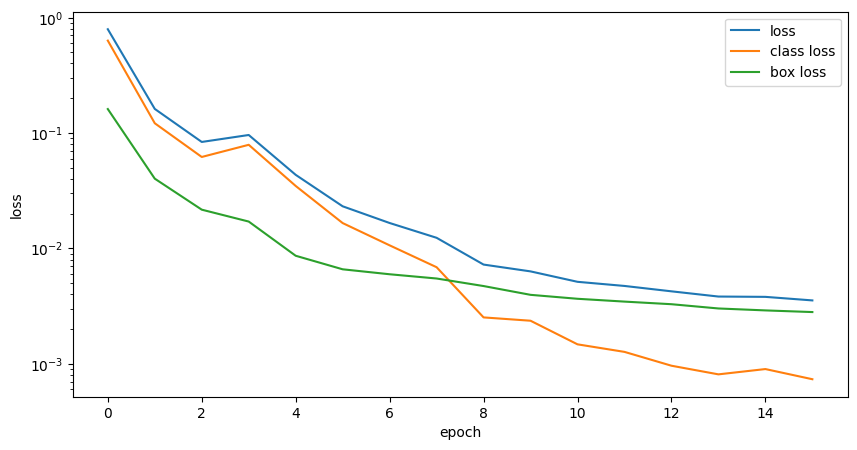

In [28]:
#with xkcd():

plt.figure(figsize=(10,5))
plt.plot(output.history['loss'],label='loss')
plt.plot(output.history['class_out_loss'],label='class loss')
plt.plot(output.history['box_out_loss'],label='box loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()


In [59]:
output.history

{'loss': [0.8637130260467529,
  0.1655193567276001,
  0.11982275545597076,
  0.061299264430999756,
  0.028886955231428146,
  0.018562939018011093,
  0.014126135036349297,
  0.010298856534063816,
  0.008830975741147995,
  0.006062252912670374,
  0.005241228733211756],
 'class_out_loss': [0.6773677468299866,
  0.1183752566576004,
  0.08990954607725143,
  0.04490984231233597,
  0.020133215934038162,
  0.011405802331864834,
  0.007509136106818914,
  0.0046244473196566105,
  0.003485274501144886,
  0.001771358074620366,
  0.0013822598848491907],
 'box_out_loss': [0.18634457886219025,
  0.04714403674006462,
  0.029913121834397316,
  0.016389448195695877,
  0.008753725327551365,
  0.007157135754823685,
  0.006616994738578796,
  0.005674411542713642,
  0.005345700308680534,
  0.0042908950708806515,
  0.0038589672185480595],
 'class_out_accuracy': [0.7908124923706055,
  0.9666875004768372,
  0.9725624918937683,
  0.9872499704360962,
  0.9947500228881836,
  0.9976875185966492,
  0.99887502193450

## 6. Validation

need to produce a validation set!!!

In [30]:
test = create_dataset(10)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 99.33it/s]


In [31]:
# Data generator for TensorFlow
def data_generator(batch_size):
    while True:
        x_batch = np.zeros((batch_size, im_size, im_size, 3))  # Initialize batch of input images
        y_batch = np.zeros((batch_size, n_objects))  # Initialize batch of class labels
        bbox_batch = np.zeros((batch_size, 3))  # Initialize batch of bounding box coordinates

        for i in range(0, batch_size):
            image, class_id, x1, y1, h = random.choice(test)  # Randomly select an example from the dataset
            x_batch[i] = np.array(image) / 255.  # Normalize and assign the image to the batch
            y_batch[i, class_id] = 1.0  # Set the class label of the corresponding object to 1.0
            bbox_batch[i] = np.array([x1, y1, h])  # Assign the normalized bounding box coordinates to the batch
            
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}  # Yield the batch of input images and corresponding labels

In [32]:
example = data_generator(1)
X_test, y_test = next(example)

1/1 [==============================] - 0s 11ms/step


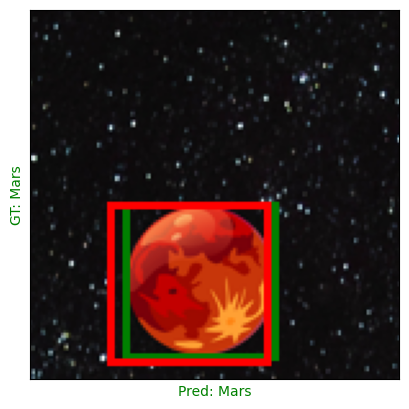

In [39]:
test_model(model, example)

## Conclusion

In this notebook, we explored object localization using TensorFlow and built a CNN model for classifying objects and predicting bounding box coordinates. We trained the model on a dataset of objects and visualized the results. In the next notebook, we will enhance our object detection capabilities using transfer learning and implement YOLOv5.